In [1]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [2]:
import utils
import keras.utils
import vgg16
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [3]:
vgg = vgg16.Vgg16()
#vgg.model.summary()

In [28]:
path = "data/dogscats/sample/"
path_model = path + "models/"

batch_size = 16

In [5]:
trn_batches = utils.get_batches(path + "train/", shuffle=False, class_mode=None, batch_size=1)
val_batches = utils.get_batches(path + "valid/", shuffle=False, class_mode=None, batch_size=1)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
# Encode class "0" or "1" into one-hot vector
trn_labels = keras.utils.np_utils.to_categorical(trn_batches.classes, nb_classes=2)
val_labels = keras.utils.np_utils.to_categorical(val_batches.classes, nb_classes=2)

In [7]:
# We need to store batches into numpy array

arr_trn_data = np.concatenate([trn_batches.next() for i in range(trn_batches.nb_sample)])
arr_valid_data = np.concatenate([val_batches.next() for i in range(val_batches.nb_sample)])

print(arr_trn_data.shape)
print(arr_valid_data.shape)

(200, 3, 224, 224)
(50, 3, 224, 224)


In [8]:
# For every image in the sample dataset, get the 1000 ImageNet categories
trn_features = vgg.model.predict(arr_trn_data, batch_size=batch_size)
val_features = vgg.model.predict(arr_valid_data, batch_size=batch_size)

print(trn_features.shape)
print(val_features.shape)

(200, 1000)
(50, 1000)


In [9]:
# Now we need to build a linear layer which will be mapping those 1000 categories to either cats or dogs
lm = keras.models.Sequential([Dense(2, input_dim=1000, activation="softmax")])
lm.compile(optimizer=RMSprop(lr=0.1), loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
lm.fit(trn_features, trn_labels, batch_size=batch_size, nb_epoch=10, validation_data=(val_features, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 0s - loss: 0.3459 - acc: 0.8850 - val_loss: 0.2907 - val_acc: 0.9000
Epoch 2/10
200/200 [==============================] - 0s - loss: 0.1525 - acc: 0.9650 - val_loss: 0.2941 - val_acc: 0.8800
Epoch 3/10
200/200 [==============================] - 0s - loss: 0.1020 - acc: 0.9600 - val_loss: 0.3197 - val_acc: 0.9000
Epoch 4/10
200/200 [==============================] - 0s - loss: 0.0782 - acc: 0.9800 - val_loss: 0.3459 - val_acc: 0.8800
Epoch 5/10
200/200 [==============================] - 0s - loss: 0.0585 - acc: 0.9800 - val_loss: 0.3894 - val_acc: 0.8400
Epoch 6/10
200/200 [==============================] - 0s - loss: 0.0468 - acc: 0.9900 - val_loss: 0.4168 - val_acc: 0.8800
Epoch 7/10
200/200 [==============================] - 0s - loss: 0.0391 - acc: 0.9900 - val_loss: 0.4561 - val_acc: 0.8800
Epoch 8/10
200/200 [==============================] - 0s - loss: 0.0335 - acc: 0.9900 - val_lo

In [11]:
val_preds = lm.predict_classes(val_features, batch_size=batch_size)
val_preds[:10]

val_probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]

16/50 [========>.....................] - ETA: 0s

In [12]:
val_labels[:10]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [13]:
val_probs[:10]

array([ 0.7007,  1.    ,  1.    ,  0.9998,  0.9992,  1.    ,  1.    ,  1.    ,  0.9999,  1.    ], dtype=float32)

In [14]:
from utils import plots
def plots_idx(idx, filenames, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [15]:
idx_good_preds = np.where(val_preds == val_labels[:,1])[0]
idx_good_preds[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

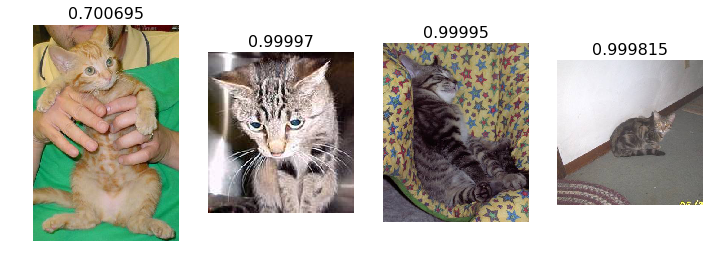

In [16]:
plots_idx(idx_good_preds[:4], val_batches.filenames, val_probs[idx_good_preds])

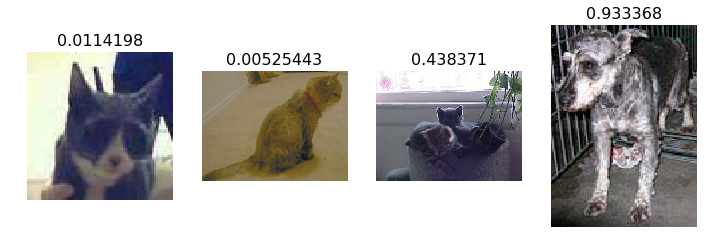

In [17]:
idx_bad_preds = np.where(val_preds != val_labels[:,1])[0]
idx_bad_preds[:10]

plots_idx(idx_bad_preds[:4], val_batches.filenames, val_probs[idx_bad_preds])

## Finetuning

Instead of building a linear model that takes our 1000 ImageNet categories and classify those into "Cats" or "Dogs", we could replace the VGG model's final layer by a 2-dim layer and retrain the model for the specific task of classifying "Cats" and "Dogs".

In [18]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [19]:
# Remove last layer
vgg.model.pop()

# Freeze all layers so that the weights won't change
for layer in vgg.model.layers: layer.trainable = False
    
# Add the final layer we want
vgg.model.add(Dense(2, activation="softmax"))

# Recompile the model
vgg.model.compile(optimizer=RMSprop(lr=0.1), loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
gen=image.ImageDataGenerator()
trn_batches = gen.flow(arr_trn_data, trn_labels, batch_size=batch_size, shuffle=False)
val_batches = gen.flow(arr_valid_data, val_labels, batch_size=batch_size, shuffle=False)

In [21]:
# Train it!
vgg.model.fit_generator(trn_batches, samples_per_epoch=trn_batches.n, validation_data=val_batches, 
                        nb_val_samples=val_batches.n, nb_epoch=3)

Epoch 1/3
200/200 [==============================] - 10s - loss: 8.3276 - acc: 0.4400 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/3
200/200 [==============================] - 10s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/3
200/200 [==============================] - 10s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


In [29]:
vgg.model.save_weights(path_model + "finetune.h5")